# Factors

## A: Standard Scaling (applied or not applied)

## B: PCA to 10 dimensions (applied or not applied)

## C: Data Augmentation (random vertical flip, applied or not applied)

## D: Model type (DecisionTreeClassifier or LogisticRegression)

# Response variable

## Accuracy

# The task

Training a classifier on a MNIST dataset

## MNIST

something something a classic benchmark for machine learning classification and more, proposed by Yann Le Cun etc. [Nice picture etc.]

# Setting

## Train test split approach

60k vs 10k (following paper by Le Cun), a single split to maintain comparability between experiments (i.e. train set and test set are always the same)

## Classifiers

Default configuration, this type of experiment makes playing aroung with hyperparameters a bit problematic

In [313]:
from sklearn.datasets import fetch_openml
import pandas as pd

try:
    X = pd.read_csv('data/X.csv', index_col=0)
    y = pd.read_csv('data/y.csv', index_col=0)
except:
    X, y = fetch_openml('mnist_784', data_home='data', version=1, return_X_y=True)

In [314]:
import matplotlib.pyplot as plt

/home/antoni/TMA4267_task_3/.venv/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


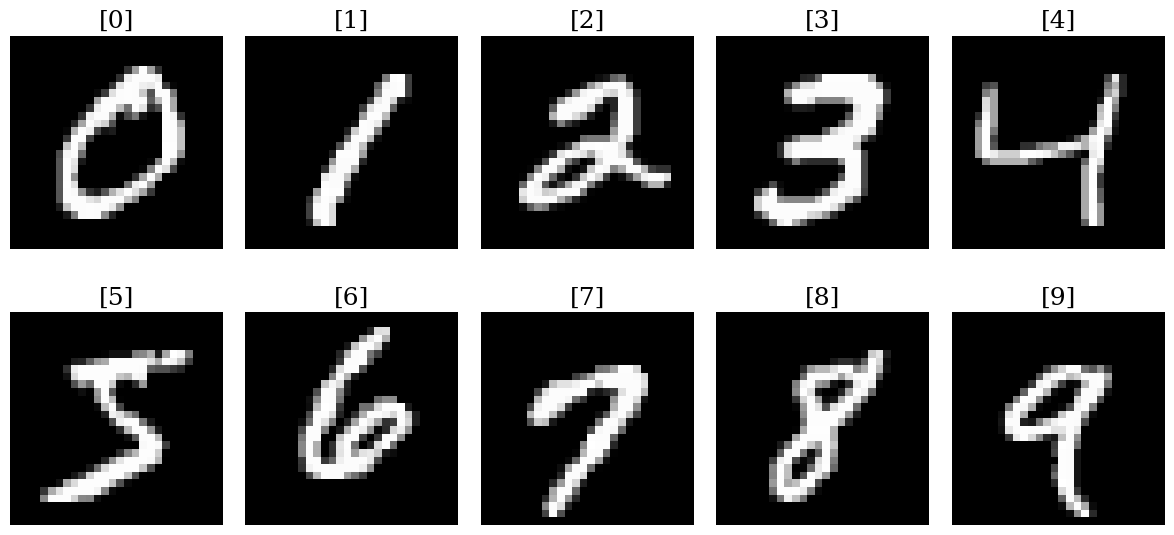

In [320]:
_, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    idx = y[y['class'] == i].index[0]
    ax.imshow(X.values[idx].reshape(28, 28), cmap='gray')
    ax.set_title(y.values[idx])
    ax.axis('off')
plt.tight_layout()
plt.savefig("mnist.png")

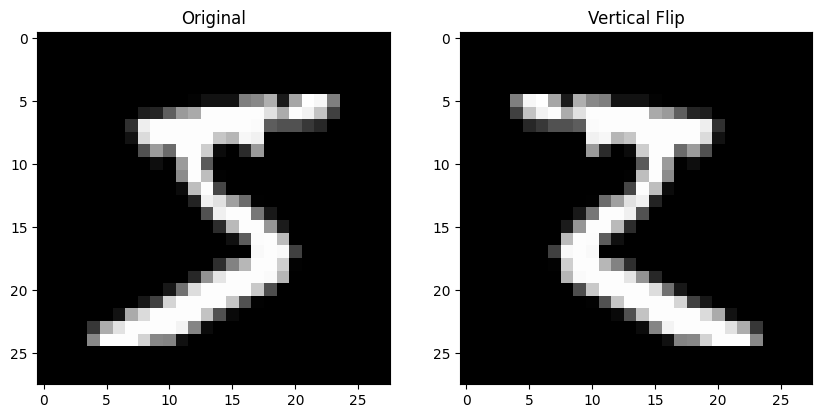

In [3]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(X.values.reshape(-1, 28, 28)[0], cmap="gray")
axs[1].imshow(X.values.reshape(-1, 28, 28)[0][:, ::-1], cmap="gray")
axs[0].set_title("Original")
axs[1].set_title("Vertical Flip")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
def train_test_data(X, y, test_size=10_000, seed=123):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    return X_train.values, X_test.values, y_train.values, y_test.values

In [6]:
from sklearn.preprocessing import StandardScaler
def standard_scaling(X_train, X_test, apply):
    if apply:
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)
    return X_train, X_test

In [7]:
from sklearn.decomposition import PCA
def pca(X_train, X_test, apply, n_components=50):
    if apply:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return X_train, X_test

In [19]:
import numpy as np


def augment_data(
    X_train: np.ndarray,
    y_train: np.ndarray,
    apply: bool,
    seed=123,
):
    if apply:
        np.random.seed(seed)
        mask = np.random.permutation(X_train.shape[0])[: X_train.shape[0] // 2]
        X_train_augmented = X_train[mask].reshape(-1, 28, 28)[:, :, ::-1].reshape(-1, 28 * 28)
        y_train_augmented = y_train[mask]
        X_train = np.concatenate([X_train, X_train_augmented], axis=0)
        y_train = np.concatenate([y_train, y_train_augmented], axis=0)

    return X_train, y_train


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
def train_model(X_train, y_train, model):
    if model:
        clf = LogisticRegression(random_state=123)
    else:
        clf = DecisionTreeClassifier(random_state=123)
    clf.fit(X_train, y_train)
    return clf
    

In [23]:
def evaluate(X_test, y_test, clf):
    return clf.score(X_test, y_test)

In [24]:
def run_single(X_train, X_test, y_train, y_test, A, B, C, D):
    X_train, X_test = standard_scaling(X_train, X_test, apply=A)
    X_train, X_test = pca(X_train, X_test, apply=B)
    X_train, y_train, X_test, y_test = get_random_shuffle(X_train, y_train, X_test, y_test, apply=C)
    clf = train_model(X_train, y_train, model=D)
    return evaluate(X_test, y_test, clf)

In [50]:
import itertools
import pandas as pd
from tqdm import tqdm

import multiprocessing

class SingleRunProcess(multiprocessing.Process):
    def __init__(self, X_train, X_test, y_train, y_test, A, B, C, D, results_q):
        multiprocessing.Process.__init__(self)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.results_q = results_q

    def run(self):
        score = run_single(self.X_train, self.X_test, self.y_train, self.y_test, self.A, self.B, self.C, self.D)
        self.results_q.put([self.A, self.B, self.C, self.D, score])



In [ ]:


def run():
    X_train, X_test, y_train, y_test = train_test_data(X, y)
    results = []
    results_q = multiprocessing.Queue()
    factors = ["A", "B", "C", "D"]
    response = ["Y"]
    for A, B, C, D in tqdm(itertools.product([True, False], repeat=4)):
        p = SingleRunProcess(X_train, X_test, y_train, y_test, A, B, C, D, results_q)
        p.start()
    
    for _ in tqdm(range(2 ** 4)):
        p.join()
        results.append(results_q.get())
    df = pd.DataFrame(results, columns=factors + response)
    df[factors] = df[factors].applymap(lambda x: {True: 1, False: -1}[x])
    for comb_size in range(1, len(factors) + 1):
        for comb in itertools.combinations(factors, comb_size):
            df["".join(comb)] = df[list(comb)].prod(axis=1)
        
    df = df[[c for c in df.columns if c != "Y"] + ["Y"]]
    df["intercept"] = 1
    return df

In [ ]:
def save_results(df):
    df.to_csv("data/results.csv")

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
df = pd.read_csv("data/results.csv", index_col=0)

In [246]:
TARGET = "Y"
FTS = [c for c in df.columns if c != TARGET]
X_, Y_ = df[FTS].values, df[TARGET].values

In [247]:
beta_hat = 1/X_.shape[0] * X_.T @ Y_
effects = 2*beta_hat

In [248]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 15,                   # Set font size to 11pt
    'axes.labelsize': 15,               # -> axis labels
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'legend.fontsize': 12,
    'lines.linewidth':2,
    'text.usetex': False,
    'pgf.rcfonts': False,
})

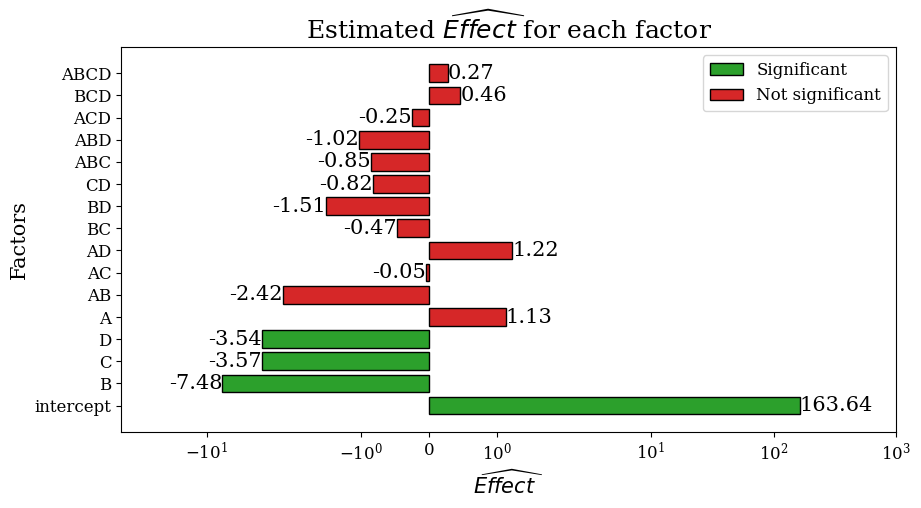

In [278]:
_, ax = plt.subplots(figsize=(10, 5))
significant_indices = np.abs(effects)>=t.interval(0.975, 5)[1]
significant_fts = np.array(FTS)[significant_indices]
not_significant_fts = np.array(FTS)[~significant_indices]
ax.barh(significant_fts, effects[significant_indices], edgecolor="black", label="Significant", color="tab:green")
ax.barh(not_significant_fts, effects[~significant_indices], edgecolor="black", label="Not significant", color="tab:red")
ax.bar_label(ax.containers[0], fmt="%.2f")
ax.bar_label(ax.containers[1], fmt="%.2f")
ax.legend(loc="upper right")
ax.set_xlabel(r"$\widehat{Effect}$")
ax.set_ylabel("Factors")
ax.set_title(r"Estimated $\widehat{Effect}$ for each factor")
ax.set_xlim(-50, 1000)
ax.set_xscale("symlog")
plt.savefig("factors_effect.png", bbox_inches="tight");

In [305]:
pred = X_ @ beta_hat
residuals = Y_ - pred

In [312]:
df

,intercept,A,B,C,D,AB,AC,AD,BC,BD,CD,ABC,ABD,ACD,BCD,ABCD,Y
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,72.38
1,1,1,1,1,-1,1,1,-1,1,-1,-1,1,-1,-1,-1,-1,77.56
2,1,1,1,-1,1,1,-1,1,-1,1,-1,-1,1,-1,-1,-1,77.65
3,1,1,1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,1,1,1,82.16
4,1,1,-1,1,1,-1,1,1,-1,-1,1,-1,-1,1,-1,-1,85.39
5,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,1,-1,1,1,86.98
6,1,1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,1,1,89.49
7,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,87.46
8,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,74.34
9,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,79.97


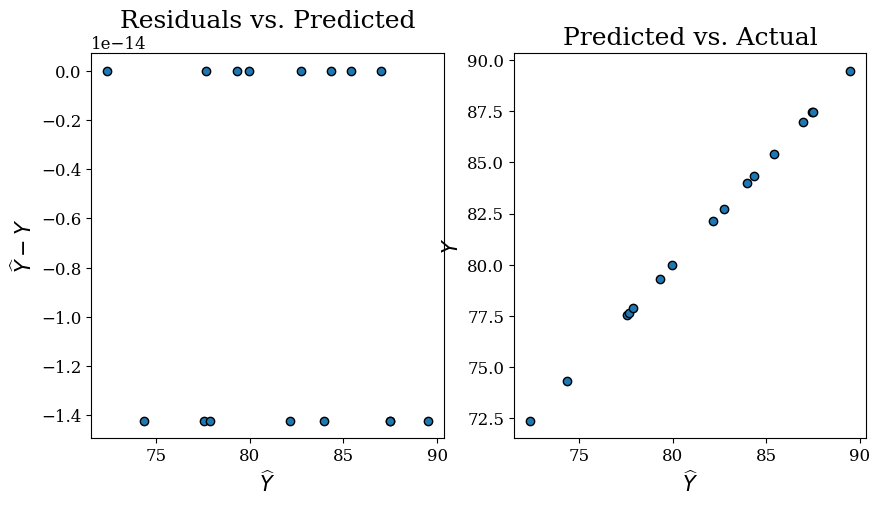

In [310]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(pred, residuals, edgecolor="black")
axs[0].set_xlabel(r"$\widehat{Y}$")
axs[0].set_ylabel(r"$\widehat{Y} - Y$")
axs[0].set_title("Residuals vs. Predicted")
axs[1].scatter(pred, Y_, edgecolor="black")
axs[1].set_xlabel(r"$\widehat{Y}$")
axs[1].set_ylabel(r"$Y$")
axs[1].set_title("Predicted vs. Actual")
plt.savefig("residuals.png", bbox_inches="tight")